## preprocessing

In [2]:
# chargement du dataset
import yaml
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ajout du dossier 'src' au chemin Python
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from data_loader import load_data, load_config
config = load_config()

# chargement du dataset
path = config['data']['raw_path']
data = load_data(path)
df = data.copy()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
plt.style.use('dark_background')
plt.rcParams.update({
    "figure.facecolor":  (0.12 , 0.12, 0.12, 1),
    "axes.facecolor": (0.12 , 0.12, 0.12, 1),
})

In [4]:
# split trainset, testset
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, train_size=0.8, shuffle=True, random_state=3)
trainset.shape

(17290, 21)

In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns, errors='ignore')

class LocationClustering(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=100, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = None
    
    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        coords = X[['lat', 'long']]
        self.kmeans.fit(coords)
        return self
    
    def transform(self, X):
        coords = X[['lat', 'long']]
        clusters = self.kmeans.predict(coords)
        X = X.copy()

        #convertion de la colonne date en format datetime
        X['date'] = pd.to_datetime(X['date'], errors='coerce') # errors = 'coerce' gère les mauvaises dates
        X['month_sold'] = X['date'].dt.month

        X['location_cluster'] = clusters
        X['sqft_living'] = np.log(X['sqft_living'])
        X['sqft_living15'] = np.log(X['sqft_living15'])
        X['sqft_above'] = np.log(X['sqft_above'])
        X = X.drop(columns=['lat', 'long'])
        return X

class TargetEncodingWrapper(BaseEstimator, TransformerMixin):
    """
    Applique un target encoding sur plusieurs colonnes, en gérant fit et transform.
    """
    def __init__(self, cols):
        self.cols = cols
        self.encoders = {}
    
    def fit(self, X, y):
        for col in self.cols:
            enc = TargetEncoder(cols=[col])
            enc.fit(X[[col]], y)
            self.encoders[col] = enc
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, enc in self.encoders.items():
            X[col] = enc.transform(X[[col]])
        return X

def preprocessing_pipeline(n_clusters=100, cols_to_encode=None):
    if cols_to_encode is None:
        cols_to_encode = ['zipcode', 'yr_built', 'yr_renovated', 'location_cluster', 'month_sold']
    
    pipeline = Pipeline([
        ('clustering', LocationClustering(n_clusters=n_clusters)),
        ('target_encoding', TargetEncodingWrapper(cols=cols_to_encode)),
        ('drop_cols', DropColumns(columns=['id', 'date']))
    ])
    
    return pipeline


In [6]:
# Séparer features et target
x_train = trainset.drop(columns=['price'])
y_train = trainset['price']

# Initialiser pipeline
pipeline = preprocessing_pipeline(n_clusters=100)

# Fit + transform sur train
x_train = pipeline.fit_transform(x_train, y_train)


In [7]:
x_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,month_sold,location_cluster
14084,3,2.00,7.319865,43560,1.0,0,0,3,7,7.319865,0,460418.652744,530484.321978,707984.710461,7.630461,67756,559342.888372,639000.815216
13750,3,2.50,7.585789,106722,1.0,0,4,3,9,7.585789,0,519221.528176,530484.321978,317907.321239,7.975908,101494,551860.338746,359585.488296
619,3,2.00,7.272398,7210,1.0,0,0,3,8,7.272398,0,513178.496437,530484.321978,332507.447099,7.438384,7245,561119.248408,313353.957280
18985,3,1.00,6.907755,5100,1.0,0,0,3,7,6.756932,140,535180.915228,530484.321978,622928.257447,6.907755,5100,538925.376502,608172.826035
21382,4,2.75,7.870930,7001,2.0,0,0,3,8,7.870930,0,541925.592424,530484.321978,445454.665412,7.870930,6543,540889.748399,410136.159189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,3,1.75,6.565265,5050,1.0,0,0,4,6,6.565265,0,484729.098822,530484.321978,423905.330961,6.802395,5050,540234.023361,444116.235088
15288,3,2.00,7.313220,5200,1.0,0,0,3,7,6.966024,440,491435.820122,530484.321978,314115.601751,7.402452,5200,551860.338746,288806.564874
11513,3,2.50,7.668561,7715,2.0,0,0,3,7,7.668561,0,609095.580414,530484.321978,306891.535662,7.595890,7628,540889.748399,282950.696129
1688,2,1.75,7.098376,131115,1.5,0,0,5,7,7.098376,0,484729.098822,530484.321978,495772.936567,7.610853,185565,549106.037351,443232.404478


In [8]:
# Pour le test (pas de fit, juste transform)
x_test = testset.drop(columns=['price'])
y_test = testset['price']

x_test = pipeline.transform(x_test)


## Modélisation

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_log_error, make_scorer
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

In [10]:
lgbmr = LGBMRegressor(random_state=3, verbose=-1)
xgbr =  XGBRegressor(random_state=3)

rp = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),LinearRegression())

et = ExtraTreesRegressor(random_state=3)
knn = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), KNeighborsRegressor(n_neighbors=50))
br = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), BayesianRidge())

In [11]:
models = {
    "LGBMRegressor": lgbmr,
    "XGBRegressor": xgbr,
    " PolynomialRegression": rp,
    "ExtraTreesRegressor": et,
    "KNeighborsRegressor": knn,
    "BayesianRidge": br
}

### NB
Bien que les modèles basés sur les arbres ne nécessitent pas de target encoding ni de transformation logarithmique, nous avons quand meme procédé à ces transformations pour pouvoir utiliser les memes données pour tous les modèles

In [12]:
# métrique customisée
def taux_surestimation(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    threshold = y_test * 0.1
    residuals = y_pred - y_test
    nbre_surestimations = 0

    for i in range (len(residuals)):
        if residuals[i] > threshold[i]:
            nbre_surestimations += 1

    rate = (nbre_surestimations * 100) / len(residuals)

    return rate 

In [13]:
def evaluation(model):
    y_train_log = np.log(y_train)
    model.fit(x_train, y_train_log)
    y_pred_log = model.predict(x_test)
    y_pred = np.exp(y_pred_log)
    
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    RMSLE = root_mean_squared_log_error(y_test, y_pred)
    rate = taux_surestimation(y_test, y_pred) #taux de surestimations supérieurs à 10%

    print(f"R2 {R2}")
    print(f"MAE {MAE}")
    print(f"MAPE {MAPE}")
    print(f"RMSLE {RMSLE}")
    print(f"Taux de surestimations > 10%: {rate:.2f}%")

    N, train_score, val_score = learning_curve(model,x_train, y_train, scoring='neg_mean_absolute_error',
                                                cv=4, train_sizes=np.linspace(0.1, 0.8, 5))


    mean_train = -train_score.mean(axis=1)  # négatif car scoring est négatif
    mean_val = -val_score.mean(axis=1)
    residus = (y_pred - y_test)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(N, mean_train, label='Training error')
    plt.plot(N, mean_val, label='Validation error')
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("MAE")
    plt.title("Courbe d'apprentissage")
    plt.legend()
    #plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.histplot(residus, kde=True)
    plt.title("Distribution des résidus")
    plt.show()


=============================LGBMRegressor=============================
R2 0.8902151786302843
MAE 69228.16662537033
MAPE 0.13057630273582999
RMSLE 0.17576436434170822
Taux de surestimations > 10%: 24.87%


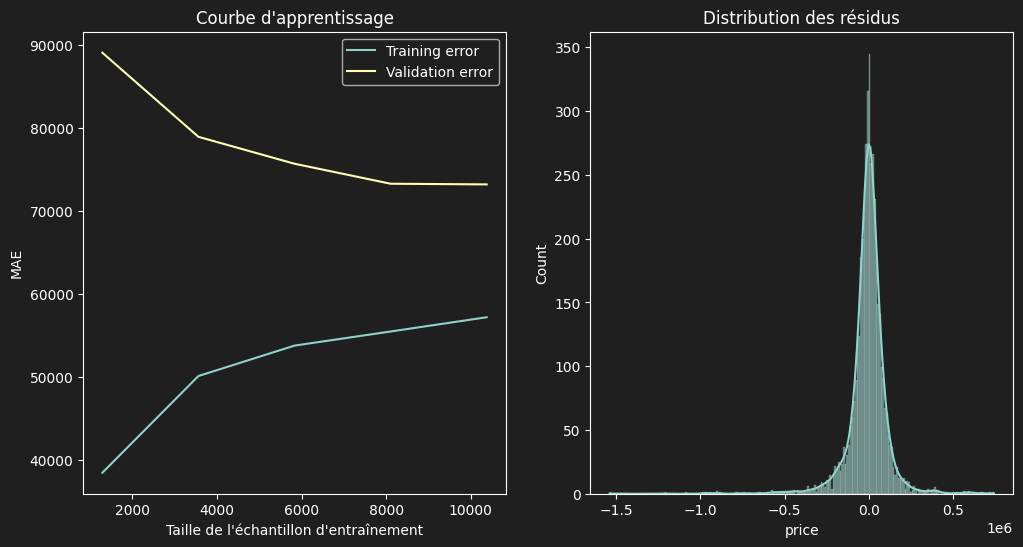

=============================XGBRegressor=============================
R2 0.8816517771639159
MAE 69578.35358113579
MAPE 0.13063666770958718
RMSLE 0.17665522787380947
Taux de surestimations > 10%: 24.27%


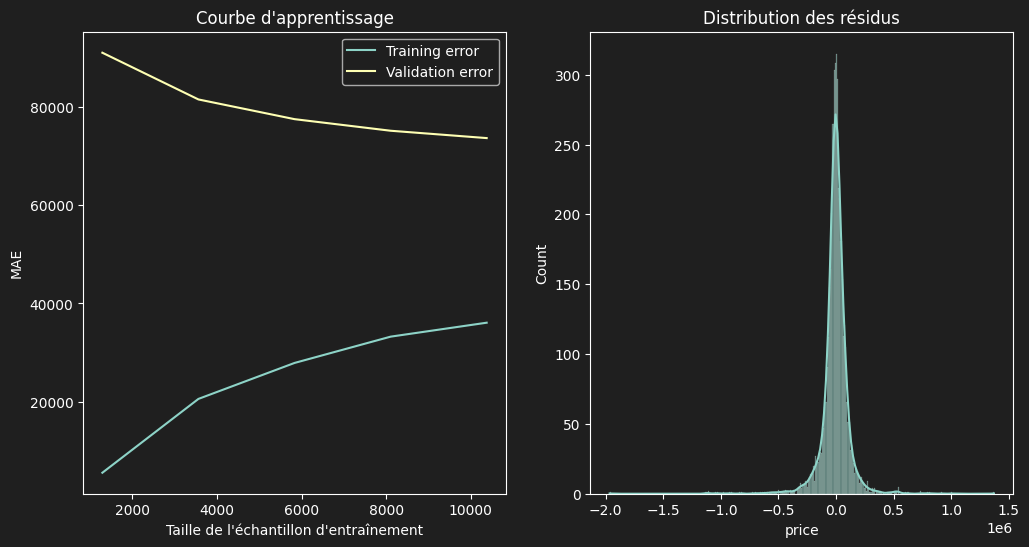

============================= PolynomialRegression=============================
R2 0.8230309840802299
MAE 85148.42849836354
MAPE 0.1575616676008265
RMSLE 0.20442873106745518
Taux de surestimations > 10%: 30.33%


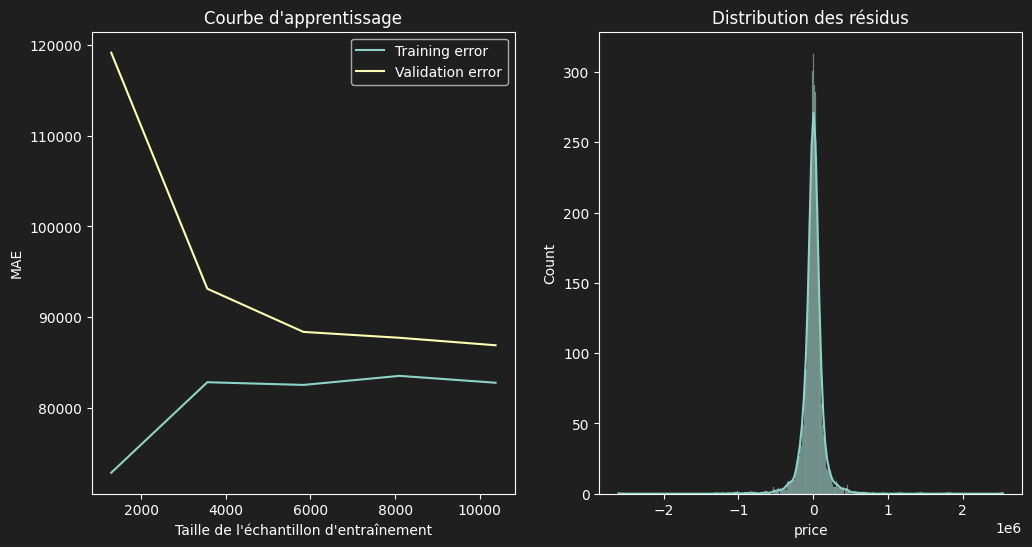

=============================ExtraTreesRegressor=============================
R2 0.8753984823131921
MAE 70873.10021761921
MAPE 0.13284114992780988
RMSLE 0.18279512783465476
Taux de surestimations > 10%: 23.11%


KeyboardInterrupt: 

In [14]:
for name, model in models.items():
    print(f'============================={name}=============================')
    evaluation(model)


<Axes: >

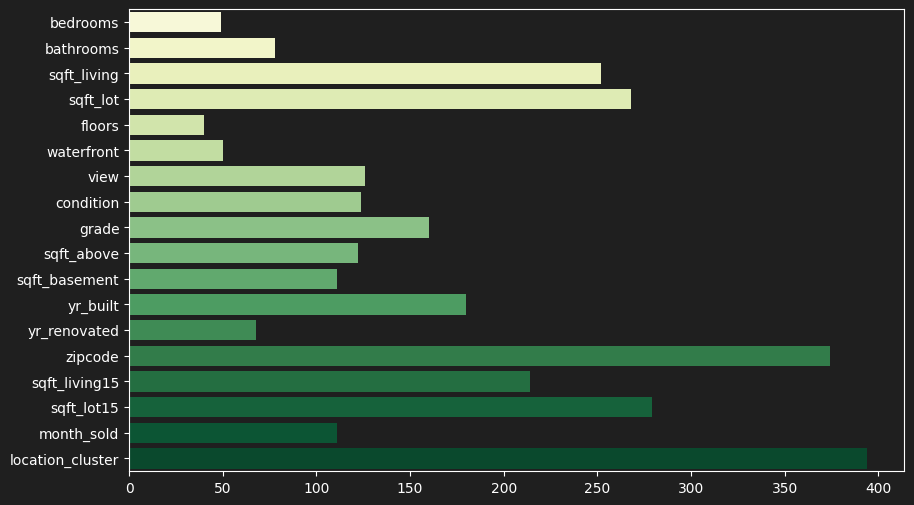

In [ ]:
# importance des variables lgbm
lgbm_importances = lgbmr.feature_importances_
names = lgbmr.feature_names_in_
plt.figure(figsize=(10, 6))
sns.barplot(x=lgbm_importances, y=names, palette='YlGn', hue=names)

<Axes: >

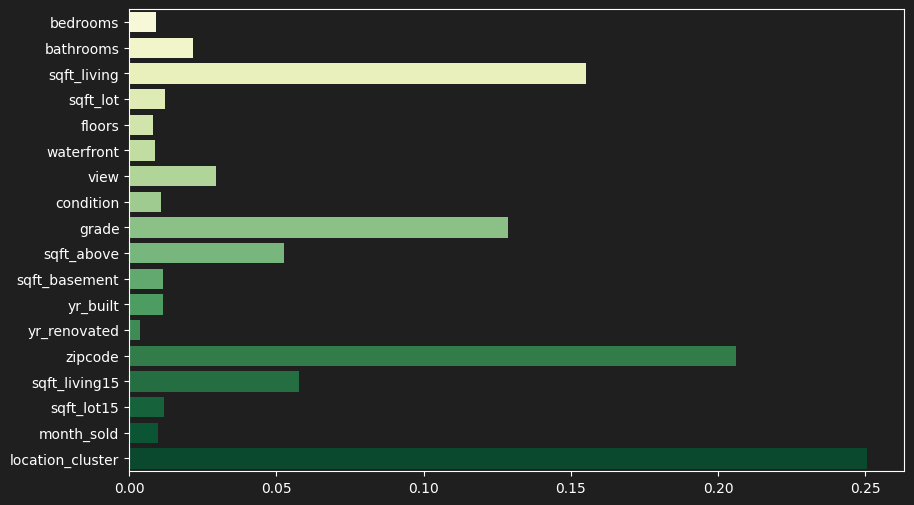

In [ ]:
# importance des variables extra trees
et_importances = et.feature_importances_
names = et.feature_names_in_
plt.figure(figsize=(10, 6))
sns.barplot(x=et_importances, y=names, palette='YlGn', hue=names)

## Stacking

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
# INITIALISATION DES MODELES

# Modèles de base
estimators = [ #("xgb", xgbr),
              ("lgbm", lgbmr),
              ("extra_trees", et)
]

# Méta-modèle
meta_model= rp # reg poly

In [ ]:
# CONSTRUCTION DU MODELE EMPILE
# integrer la modèle dans une pipeline pour GridSearchCV
stacking_model = make_pipeline(StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    passthrough=True  # permet au méta-modèle de voir aussi les features originales
))

In [ ]:
# ENTRAINEMENT
y_train_log = np.log(y_train)
stacking_model.fit(x_train, y_train_log)

Pipeline(steps=[('stackingregressor',
                 StackingRegressor(cv=5,
                                   estimators=[('lgbm',
                                                LGBMRegressor(random_state=3,
                                                              verbose=-1)),
                                               ('extra_trees',
                                                ExtraTreesRegressor(random_state=3))],
                                   final_estimator=Pipeline(steps=[('polynomialfeatures',
                                                                    PolynomialFeatures(include_bias=False)),
                                                                   ('linearregression',
                                                                    LinearRegression())]),
                                   passthrough=True))])

In [ ]:
lgbmr.fit(x_train, y_train_log)

NameError: name 'lgbmr' is not defined

In [ ]:
y_pred_log = stacking_model.predict(x_test)

y_pred = np.exp(y_pred_log) 

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
RMSLE = root_mean_squared_log_error(y_test, y_pred)
rate = taux_surestimation(y_test, y_pred)

print(f"R2 {R2}")
print(f"MAE {MAE}")
print(f"MAPE {MAPE}")
print(f"RMSLE {RMSLE}")
print(f"Taux de surestimations > 10%: {rate:.2f}%")

R2 0.894874917983101
MAE 68095.59071470264
MAPE 0.1290521426099699
RMSLE 0.17399181450492787
Taux de surestimations > 10%: 24.24%


R2 0.894874917983101
MAE 68095.59071470264
MAPE 0.1290521426099699
RMSLE 0.17399181450492787
Taux de surestimations > 10%: 24.24%


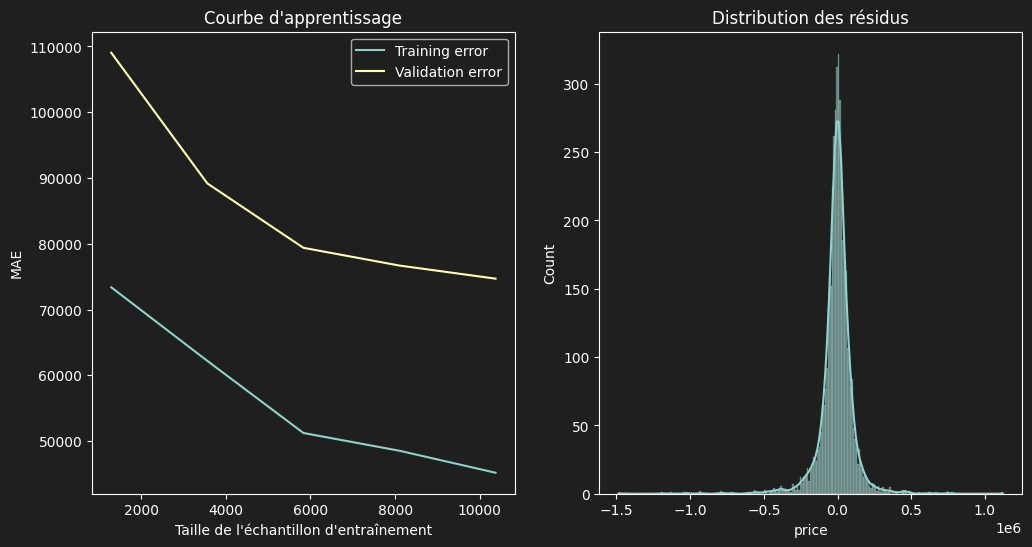

In [ ]:
evaluation(stacking_model)

In [ ]:
stacking_model

Pipeline(steps=[('stackingregressor',
                 StackingRegressor(cv=5,
                                   estimators=[('lgbm',
                                                LGBMRegressor(random_state=3,
                                                              verbose=-1)),
                                               ('extra_trees',
                                                ExtraTreesRegressor(random_state=3))],
                                   final_estimator=Pipeline(steps=[('polynomialfeatures',
                                                                    PolynomialFeatures(include_bias=False)),
                                                                   ('linearregression',
                                                                    LinearRegression())]),
                                   passthrough=True))])